In [1]:
%matplotlib inline

import seaborn as sns
import pandas as pd
import pysal as ps
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import mstats
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
# run for jupyter notebook
from IPython.core.debugger import Tracer
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
#%%

/home/alal/anaconda3/envs/gds/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Shapefiles

In [2]:
root = '/home/alal/Desktop/data/Boundaries/Nepal_Admin_Boundaries'
%cd $root
# l1 = gpd.read_file('Regions Level 1.shp')
# l2 = gpd.read_file('Zones Level 2.shp')
# l5 = gpd.read_file('Wards Level 5.shp')
l3 = gpd.read_file('Districts Level 3.shp')
l4 = gpd.read_file('Village Development Committees Level 4.shp')

/home/alal/Desktop/data/Boundaries/Nepal_Admin_Boundaries


## Household Data

In [3]:
working = '/home/alal/Desktop/code/eq-svy-eda'
maproot = '/home/alal/Desktop/code/eq-svy-eda/reports/maps'
%cd $working
%time hh_all = pd.read_csv(working+'/data/interim/hh_with_geo.csv')

/home/alal/Desktop/code/eq-svy-eda


<string>:2: DtypeWarning: Columns (33,34) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 10.6 s, sys: 751 ms, total: 11.3 s
Wall time: 11.3 s


In [4]:
hh_all['vdc']=hh_all['VDC-Municipality-Name'].str.lower()

In [5]:
main_dists = hh_all.loc[hh_all.FullSample==1].District_Name.unique()
main_dists

array(['okhaldhunga', 'sindhuli', 'ramechhap', 'dolakha', 'sindhupalchok',
       'kavrepalanchok', 'nuwakot', 'rasuwa', 'dhading', 'makwanpur',
       'gorkha'], dtype=object)

### Subset and Merge - District Level

In [6]:
l3['District'] = l3['DISTRICT'].str.lower()

In [7]:
remaps = {"makawanpur": "makwanpur",
         "kabhrepalanchok": "kavrepalanchok",
         "chitawan": "chitwan"}
l3['District'].replace(remaps, inplace=True)
main_dists_shp = l3.loc[l3['District'].isin(main_dists)]

In [8]:
main_dists_eq = hh_all[hh_all['District_Name'].isin(main_dists)]

In [9]:
# set income to lower-bound of each bin
incomes = {
    'Rs. 10 thousand':5000, 
    'Rs. 10-20 thousand':10000,
    'Rs. 20-30 thousand':20000, 
    'Rs. 30-50 thousand':30000, 
    'Rs. 50 thousand or more':50000
}
main_dists_eq['income'] = main_dists_eq['income_level_household'].map(incomes)

/home/alal/anaconda3/envs/gds/lib/python3.5/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


### Functions to group and plot

In [10]:
def aggregate_indicator(var,oper='sum'):
    dist_lev_tallies = main_dists_eq.groupby('District_Name').agg({
        'household_id': 'count',
        var : oper
    })
    dist_lev_tallies.reset_index(inplace=True)
    dist_lev_tallies.rename(columns={'household_id': 'number_of_households'}, inplace=True)
    if oper == 'sum':
        dist_lev_tallies['share_with_'+var]=\
                        (dist_lev_tallies[var]/\
                        dist_lev_tallies.number_of_households)*100
    return dist_lev_tallies

In [11]:
def plot_variable(df,varn,save=False,label=''):
    merged_dist = main_dists_shp.merge(df,
                     left_on='District',right_on='District_Name')
    merged_dist['coords'] = merged_dist['geometry'].apply(lambda x: x.representative_point().coords[:])
    merged_dist['coords'] = [coords[0] for coords in merged_dist['coords']]
    f, ax = plt.subplots(1,dpi=300)
    merged_dist.plot(column=varn,ax=ax,cmap=plt.cm.viridis,
                    legend=True,linewidth=5)
    for idx, row in merged_dist.iterrows():
        plt.annotate(s=row['District'], xy=row['coords'],
                     horizontalalignment='center',size=5)
    ax.set_axis_off()
    if label == '' : 
        label = varn
    f.suptitle(label)
    if save:
        plt.savefig('{0}_plot.png'.format(varn), dpi=300)
        plt.clf()

## District level summaries and plots

District_Name  has_death_occurred_last_12_months  number_of_households  \
0          dhading                             1921.0                 80942   
1          dolakha                              897.0                 68112   
2           gorkha                             1556.0                 69328   
3   kavrepalanchok                             1784.0                 80972   
4        makwanpur                             1182.0                 68628   
5          nuwakot                             2254.0                 75454   
6      okhaldhunga                              563.0                 32678   
7        ramechhap                              739.0                 47817   
8           rasuwa                              630.0                 12384   
9         sindhuli                              698.0                 52252   
10   sindhupalchok                             3931.0                 79822   

    share_with_has_death_occurred_last_12_months  
0                                       2.373304  
1                                       1.316949  
2                                       2.244403  
3                                       2.203231  
4                                       1.722329  
5                                       2.987251  
6                                       1.722872  
7                                       1.545475  
8                                       5.087209  
9                                       1.335834  
10                                      4.924707

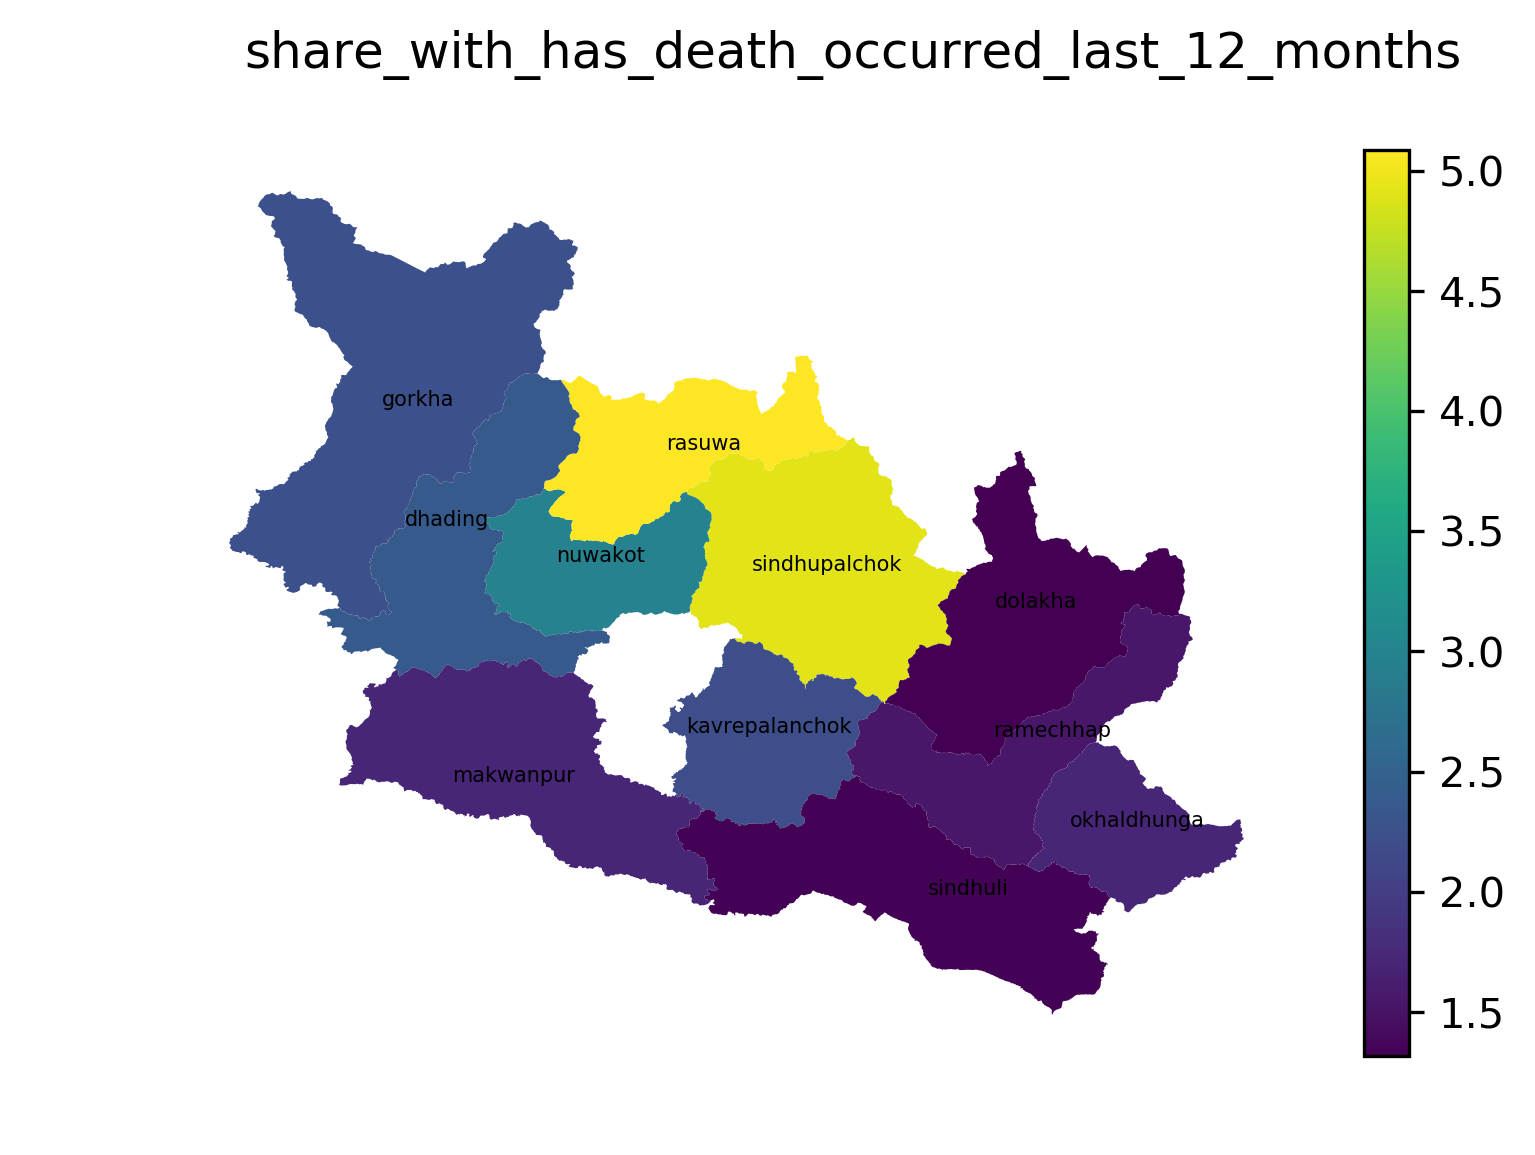

In [12]:
v = 'has_death_occurred_last_12_months'
df = aggregate_indicator(v)
df
plot_variable(df,'share_with_'+v)

District_Name  is_recipient_rahat_10k  number_of_households  \
0          dhading                   65321                 80942   
1          dolakha                   52101                 68112   
2           gorkha                   55935                 69328   
3   kavrepalanchok                   58435                 80972   
4        makwanpur                    5643                 68628   
5          nuwakot                   65525                 75454   
6      okhaldhunga                   12984                 32678   
7        ramechhap                   42337                 47817   
8           rasuwa                    9936                 12384   
9         sindhuli                   17153                 52252   
10   sindhupalchok                   69092                 79822   

    share_with_is_recipient_rahat_10k  
0                           80.700996  
1                           76.493129  
2                           80.681687  
3                           72.166922  
4                            8.222591  
5                           86.840989  
6                           39.733154  
7                           88.539641  
8                           80.232558  
9                           32.827452  
10                          86.557591

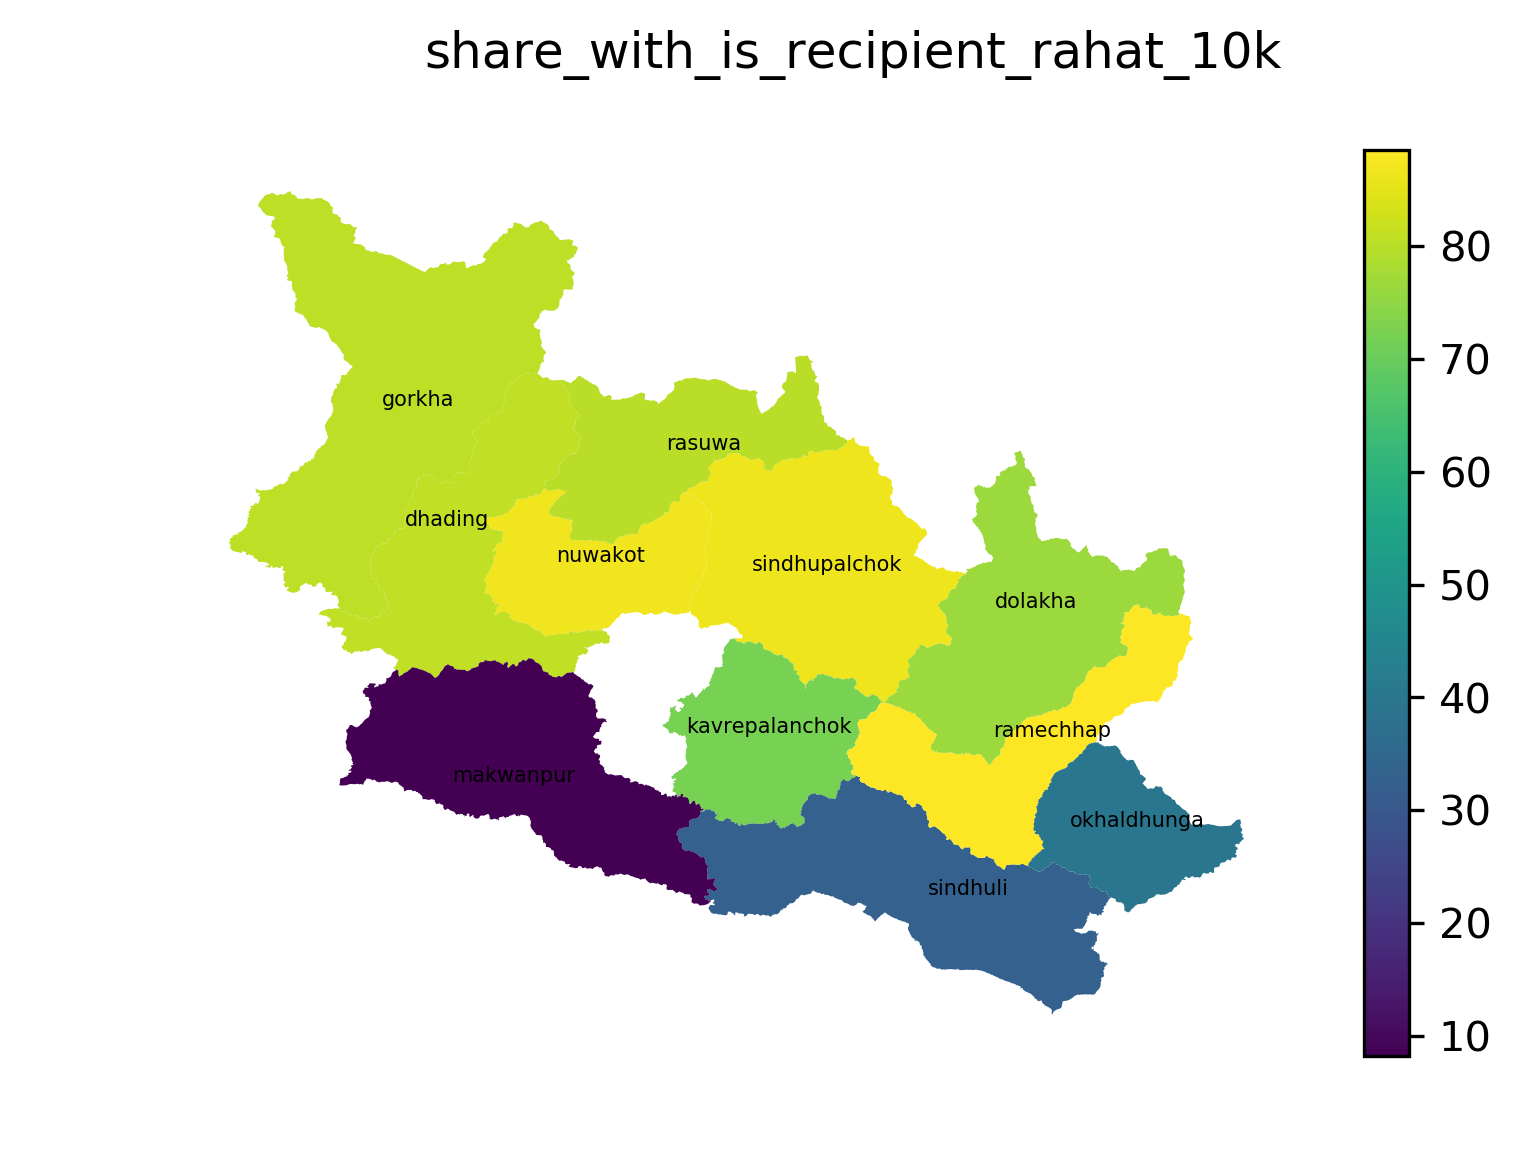

In [13]:
v = 'is_recipient_rahat_10k'
df = aggregate_indicator(v)
df
plot_variable(df,'share_with_'+v)

District_Name        income  number_of_households
0          dhading   9612.575087                 80942
1          dolakha   9560.717065                 68112
2           gorkha   9771.861472                 69328
3   kavrepalanchok  10103.752378                 80972
4        makwanpur   9660.899503                 68628
5          nuwakot   9369.009267                 75454
6      okhaldhunga   7526.778063                 32678
7        ramechhap   7848.581827                 47817
8           rasuwa   9491.518578                 12384
9         sindhuli   7762.168163                 52252
10   sindhupalchok   9645.850823                 79822

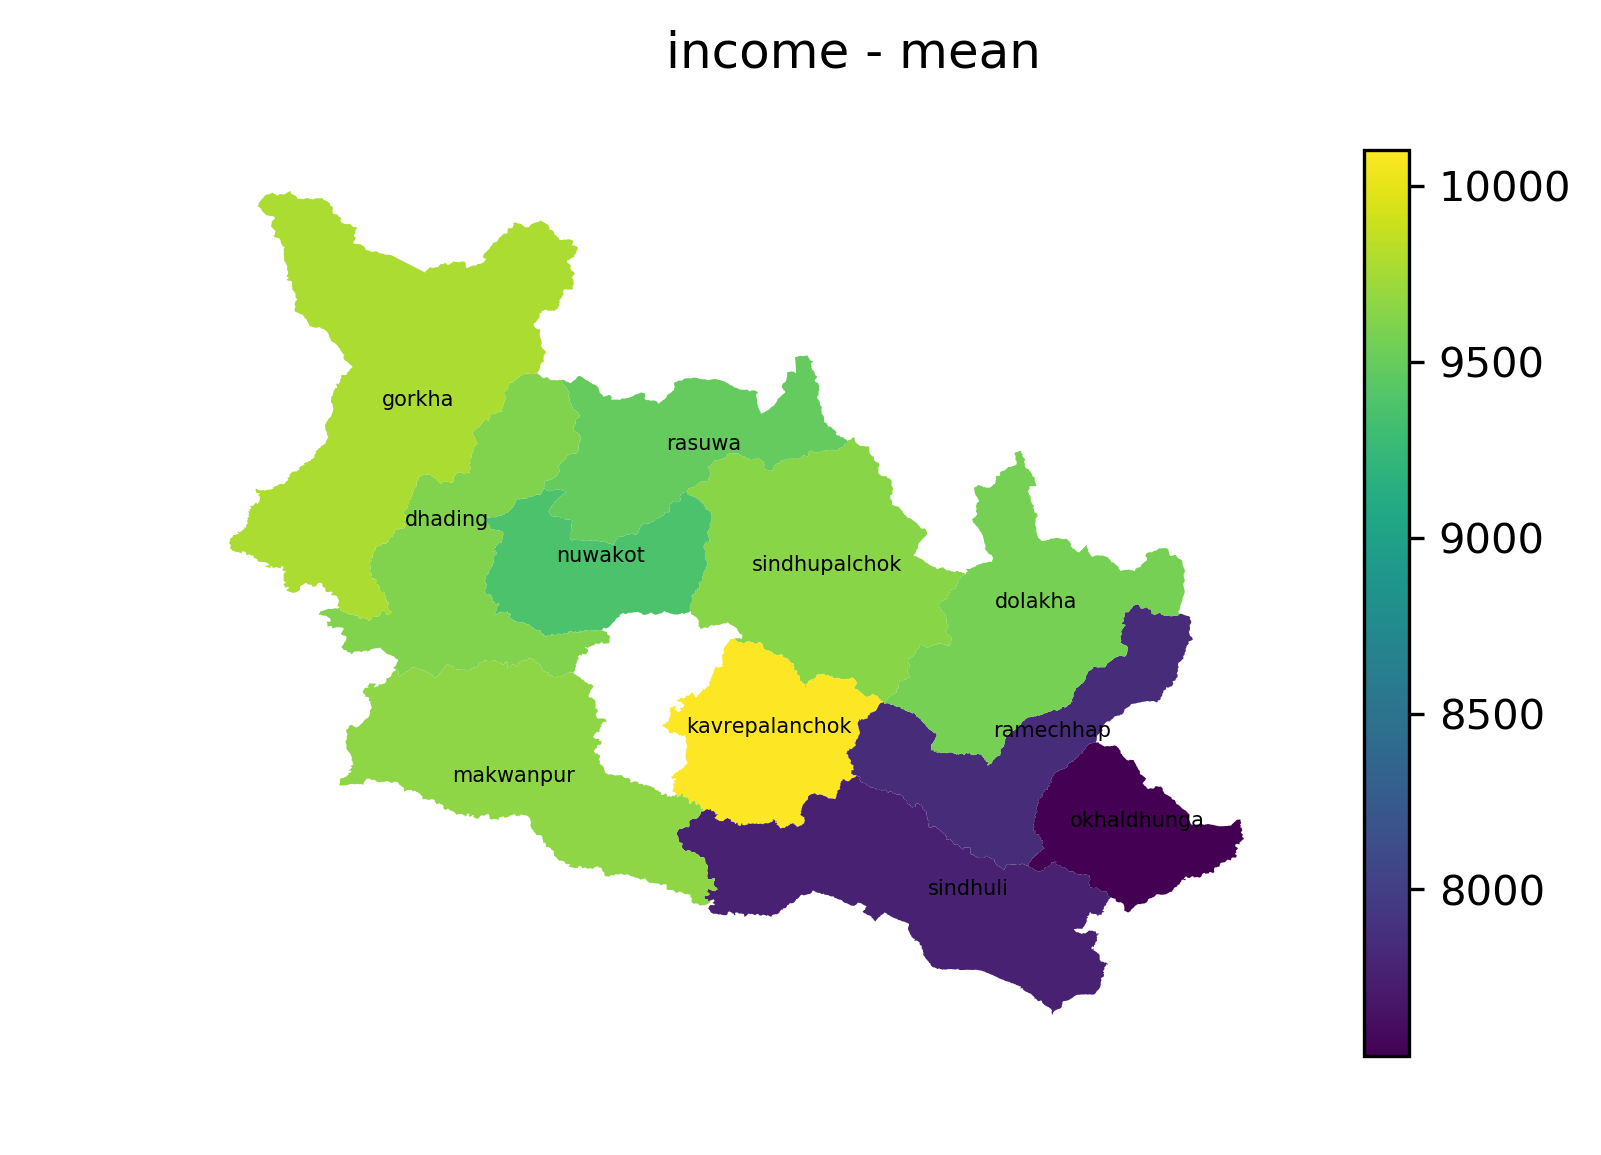

In [14]:
v = 'income'
aggregate_indicator(v,oper='mean')
plot_variable(aggregate_indicator(v,oper='mean'),v,label='income - mean')

District_Name       income  number_of_households
0          dhading  7486.948590                 80942
1          dolakha  7146.871076                 68112
2           gorkha  8198.749024                 69328
3   kavrepalanchok  7603.916667                 80972
4        makwanpur  7861.461098                 68628
5          nuwakot  7136.288861                 75454
6      okhaldhunga  5539.319201                 32678
7        ramechhap  5700.993407                 47817
8           rasuwa  7130.080013                 12384
9         sindhuli  5528.135851                 52252
10   sindhupalchok  7809.010257                 79822

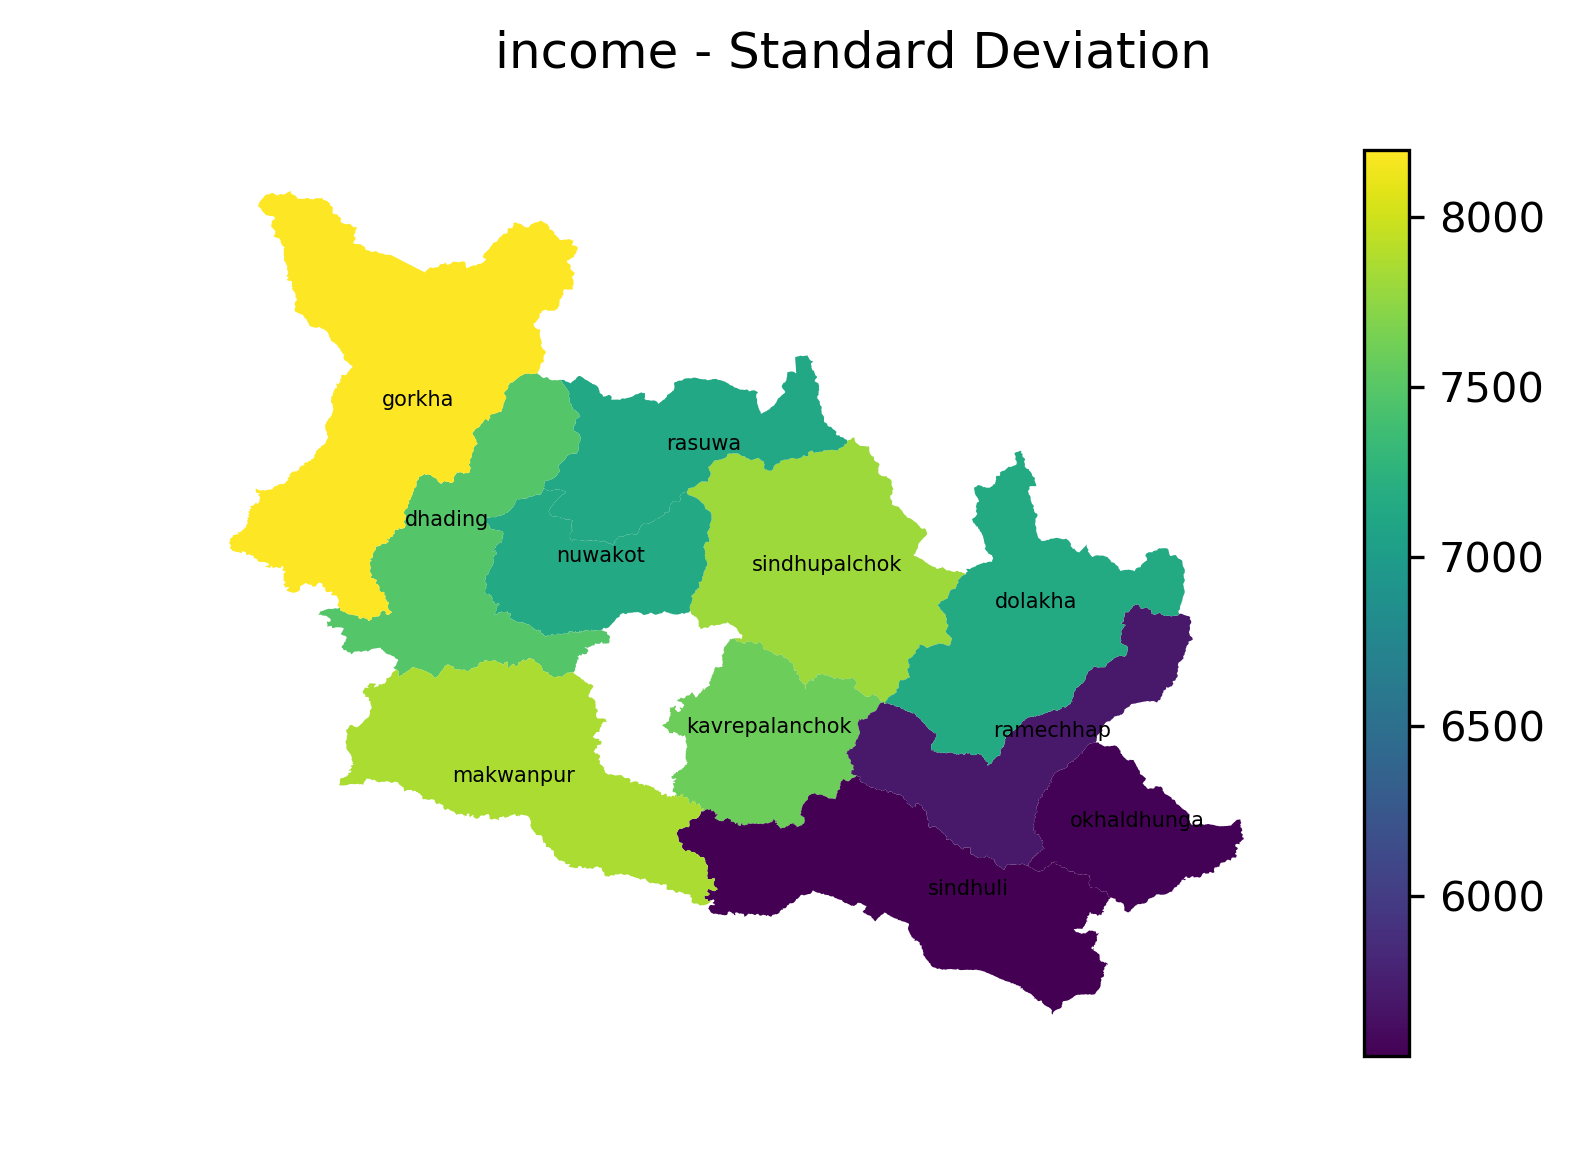

In [15]:
v = 'income'
aggregate_indicator(v,oper='std')
plot_variable(aggregate_indicator(v,oper='std'),v,label='income - Standard Deviation')

In [16]:
%cd $maproot

/home/alal/Desktop/code/eq-svy-eda/reports/maps


In [17]:
! mkdir 'district_level' -p

In [18]:
%cd 'district_level'

/home/alal/Desktop/code/eq-svy-eda/reports/maps/district_level


In [19]:
list_of_cols = ['is_bank_account_present_in_household',
    'has_death_occurred_last_12_months', 
    'has_injury_loss_occurred_last_12_months',
    'has_education_drop_occurred_last_12_months',
    'has_pregnancy_treatment_drop_occurred_last_12_months',
    'has_vaccination_drop_occurred_last_12_months',
    'has_occupation_change_occurred_last_12_months',
    'count_occupation_change_last_12_months',
    'is_recipient_rahat_15k', 'is_recipient_rahat_10k',
    'is_recipient_rahat_200k', 'is_recipient_rahat_social_security_3k',
    'is_recipient_rahat_none', 'is_ineligible_rahat',
    'has_asset_land_pre_eq', 'has_asset_tv_pre_eq',
    'has_asset_cable_pre_eq', 'has_asset_computer_pre_eq',
    'has_asset_internet_pre_eq', 'has_asset_telephone_pre_eq',
    'has_asset_mobile_phone_pre_eq', 'has_asset_fridge_pre_eq',
    'has_asset_motorcycle_pre_eq',
    'has_asset_four_wheeler_family_use_pre_eq',
    'has_asset_four_wheeler_commercial_use_pre_eq', 'has_asset_none_pre_eq',
    'has_asset_land_post_eq', 'has_asset_tv_post_eq',
    'has_asset_cable_post_eq', 'has_asset_computer_post_eq',
    'has_asset_internet_post_eq', 'has_asset_telephone_post_eq',
    'has_asset_mobile_phone_post_eq', 'has_asset_fridge_post_eq',
    'has_asset_motorcycle_post_eq',
    'has_asset_four_wheeler_family_use_post_eq',
    'has_asset_four_wheeler_commercial_post_eq', 'has_asset_none_post_eq'
]

In [20]:
%%capture
for v in list_of_cols:
    plot_variable(aggregate_indicator(v),'share_with_'+v,True)

#### Merge Village level

In [21]:
dist_remaps = {"makawanpur": "makwanpur",
         "kabhrepalanchok": "kavrepalanchok",
         "chitawan": "chitwan"}

In [22]:
l4['District'] = l4['DIST_NAME'].str.lower()
l4['Vdc'] = l4['VDC_NAME'].str.lower()
l3['District'].replace(dist_remaps, inplace=True)
main_dists_shp = l4.loc[l4['District'].isin(main_dists)]
main_dists_shp.shape

(627, 12)

#### remaps for village names - i wish i had an RA

In [23]:
remaps = {
    "aaru arbang": "aaruaarbad",
    "aaru chanaute": "aaruaarbad",
    "aarupokhari": "aaruaarbad",
    "agara": "agra",
    "alampu": "alambu",
    "ambote": "shikhar ambote",
    "atarpur": "attarpur",
    "badegau": "bandegaun",
    "bageswori": "bageshwari",
    "baksa": "baksha",
    "baldthali": "balthali",
    "balting": "walting",
    "bamti bhandar": "baluwa pati naldhun",
    "baramchi": "baramchae",
    "barpak": "warpak",
    "baruneshwor": "barudeshwor",
    "bhaise": "bhainse",
    "bharta pundyadevi": "bhartapunyadevi",
    "bhedapu": "bhedpu",
    "bhimeshwor municipality": "bhimeswor municipality",
    "bhimfedi": "bhimphedi",
    "bhotasipa": "bhotsipa",
    "bhote namlang": "bhotenamlang",
    "bhujee": "bhuji",
    "bhumesthan": "bhumisthan",
    "bhusafeda": "bhusaphedi",
    "bhussinga": "bhushanga",
    "bitijor bagaiya": "bitijor bagaincha",
    "bocha": "boch",
    "bolde fediche": "boldephadiche",
    "bridhim": "briddim",
    "chalal ganeshsthan": "chalalganeshsthan",
    "chankhu": "changkhu",
    "chaughada": "chaughoda",
    "chautara n.p.": "chautara",
    "chhatredeurali": "chhatre deurali",
    "chilankha": "chilangkha",
    "choubas": "chaubas",
    "chumchet": "chunchet",
    "chyasing kharka": "chyasingkharka",
    "bhadrutar": "bhadratar",
    "baluwapati deupur": "baluwadeubhumi",
    "bekhsimle ghartigaun": "bekhsimle ghartigaon",
    "banakhu chor": "wanakhu",
    "bhumlichok": "mumlichok",
    "dadiguranshe": "dandiguranse",
    "dandagaun/dandaghar": "dandagaun",
    "dandagoun": "danda gaun",
    "dapcha kasikhanda n.p.": "dapcha chatraebangha",
    "dhola": "dhol",
    "dhunkharka": "dhungkharka bahrabisae",
    "dudbhanjyang": "dudhbhanjyang",
    "dhussa": "dhursa",
    "dudhouli n.p.": "dudhauli",
    "dhuseni siwalaya": "ghusenisiwalaye",
    "dubachour": "dubachaur",
    "dhuskun": "gunsakun",
    "fakhel": "phakhel",
    "farpu": "tharpu",
    "falate bhumlu": "phalete",
    "falemetar": "phalametar",
    "faparbari": "phaparbari",
    "fasku": "phasku",
    "fediguth": "phedighooth",
    "fikuri": "phikuri",
    "foksingtar": "phoksingtar",
    "fujel": "phujel",
    "fulbari": "phulbari",
    "fulpingdanda": "phulchodanda",
    "fulpingkatti": "phulpingkatti",
    "fulpingkot": "phulpingkot",
    "gairi bisouna deupur": "gairi bisauna deupur",
    "ganeshthan": "ganeshsthan",
    "gankhu": "gangkhu",
    "gauri sankar": "gaurishankar",
    "ghyang sukathokar": "ghyangsukathokar",
    "gloche": "golche",
    "gogane": "gomane",
    "goswara": "goshwara",
    "gothpani": "gotpani",
    "gunsakot": "ghunsakot",
    "gunsi bhadaure": "gunsi",
    "gupteshwor": "gupteshwar",
    "halde kalika": "kalika halldae",
    "hariharpur gadhi": "hariharpurgadhi",
    "jalkanya": "jalkanyachapauli",
    "jeewanpur": "jiwanpur",
    "jhyaku": "jhyanku",
    "jiri n.p.": "jiri",
    "jyamrung": "jyamere",
    "kabhre": "kabre",
    "kalati bhumidanda": "kapali bhumaedanda",
    "kalinchowk": "kalinchok",
    "kalpabrishykha": "kalpabrikshya",
    "kamalamai municipality": "kamalami municipality",
    "kankada": "kangkada",
    "katike deurali": "kattike deurali",
    "katunje besi": "katunjebesi",
    "kerauja": "keroja",
    "kewalpur": "kebalpur",
    "khadag bhanjyang": "khadga bhanjyang",
    "khahare pangu": "khaharepangu",
    "khang sang": "khangsang",
    "khiji chandeshwori": "khijichandeshwori",
    "khigikati": "khijikaanthi",
    "khijifalate": "khijiflate",
    "kimtang": "kintang",
    "kiwool": "kiul",
    "kogate": "kagate",
    "kolati bhumlu": "kolanti",
    "kubukasthali": "kunbhukasthali",
    "kuibhir": "kuebhire",
    "kuseswor dumja": "kusheshwar dumja",
    "kyaneshwor": "kyaneshwar",
    "laharepouwa": "laharepauwa",
    "langarche": "lagarche",
    "lisankhu": "lisangkhu",
    "listikot": "listokot",
    "madan kundari": "madankundari",
    "madhavpur": "madhabpur",
    "mahadevdada": "mahadevdanda",
    "mahankal": "mahangkal",
    "mahankal chaur": "mahangkal",
    "mahendra jhyadi": "mahendrajhyadi",
    "mahendra jyoti": "mahendrajyoti bansdol",
    "majhi feda": "majhipheda",
    "makadum": "makadhum",
    "makwanpurgadhi": "makawanpur gadhi",
    "maneswnara": "maneswar",
    "mankha": "mangkha",
    "melamchi n.p.": "melamchi",
    "muchhok": "muchchok",
    "nagre gagarche": "nangregagarche",
    "namdu": "namdru",
    "mirkot": "virkot",
    "narmedeshwor": "narmadeshwor",
    "nayagaun deupur": "naya gaun deupur",
    "ramechhap municipality": "ramechhap",
    "manthali municipality": "ramechhap",
    "nilkantha n.p.": "nilkanth",
    "orang": "worang",
    "pagretar": "pangretar",
    "palte": "patale",
    "palungtar municipality": "palungtar",
    "patalekhet": "phalete",
    "panchkhal n.p.": "panchkhal",
    "petaku": "pedku",
    "pinkhuri": "phikuri",
    "pritee": "priti",
    "purano jhangajholi": "puranojhangajholi",
    "raniban": "ranibaan",
    "ratanchura": "ratanchur",
    "ravi opi": "rabiopi",
    "rawadolu": "rawadol",
    "ree gaun": "rigaun",
    "ryale": "ryale bihawar",
    "sahare": "shahare",
    "sailungeswor": "sailungeshwar",
    "salle bhumlu": "salle blullu",
    "salmechakala (taldhunga)": "salme taldhunga",
    "salyantar": "salyan tar",
    "samundradevi": "samudradevi kholegaun",
    "samundratar": "samudratar",
    "sanghutar": "sandhutar",
    "sankhupati chour": "sangkhupatichaur",
    "sanowangthali": "sanuwangthali",
    "santeswori (rampur)": "shanteshwari rampur",
    "sarada batase": "sharada (batase)",
    "sarasyunkhark": "sarsyunkharka",
    "sarikhet palase": "sarikhetpalase",
    "saurpani": "sairpani",
    "semjong": "semdhung",
    "serna": "sherma",
    "shreechaur": "shrichaor",
    "shreenathkot": "shrithankot",
    "shreepur chhatiwan": "shripur chhatiwan",
    "simalchour syampati": "syampati simalchaur",
    "sipa pokhare": "sipapokharae",
    "sipal kavre": "sinpal kavre",
    "sirthouli": "sirthauli",
    "sunam pokhari": "sumnampokhari",
    "syafru": "syaphru",
    "solpathana": "swalpathana",
    "sidhdhicharan n.p.": "shishneri",
    "sikhar ambote": "shikhar ambote",
    "sisneri mahadevsthan": "shishneri",
    "syaule bazar": "syaule",
    "takukot": "tarkukot",
    "takumajh lakuribot": "takumaj hlakuri",
    "taluwa": "tuluwa",
    "thampal chhap": "thumpakhar",
    "thangpalkot": "thapalkot",
    "thumi": "thumo",
    "tistung deurali": "tistung",
    "tokarpur": "thokarpur",
    "toksel": "tokshel",
    "tosramkhola": "tosarangkhola",
    "tukucha nala": "tukuchanala",
    "ugrachandi nala": "ugrachandinala",
    "yamunadanda": "yamuna danda",
    "yasam": "yesham",
    "thulachhap": "thulachaap",
    "thulogoun": "thulo gaun",
    "thum pakhar": "thumpakhar",
    "dhaibung": "jibjibe (nilkantha)",
    "dhumthang": "sindhukot",
    "dhunwakot": "ghunsakot",
    "gorkha municipality": "prithbinarayan municipality",
    "majuwa": "makadhum",
    "pokhari chauri": "chauri pokhari",
    "tamchet dudhpokhari": "dodhapokhari",
    "thaha n.p.": "bhimphedi"
}


In [24]:
main_dists_eq['vdc'].replace(remaps, inplace=True)

/home/alal/anaconda3/envs/gds/lib/python3.5/site-packages/pandas/core/generic.py:4619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Aggregate statistics to village level

In [25]:
def village_agg_indicator(var,oper='sum'):
    vdc_lev_tallies = main_dists_eq.groupby('vdc').agg({
        'household_id': 'count',
        var : oper,
        'District_Name': 'first'
    })
    vdc_lev_tallies.reset_index(inplace=True)
    vdc_lev_tallies.rename(columns={'household_id': 'number_of_households'}, inplace=True)
    if oper == 'sum':
        vdc_lev_tallies['share_with_'+var]=\
                        (vdc_lev_tallies[var]/\
                        vdc_lev_tallies.number_of_households)*100
    return vdc_lev_tallies

In [26]:
def plot_var_village(df,v,dist=' ',save=False,winsor=False,ub=0.99,label=''):
    # subset shapefile and sumstats file if dist is specified
    if dist != ' ':
        df1 = main_dists_shp.loc[main_dists_shp['District'] == dist ]
        df2 = df.loc[df['District_Name']== dist]
    else:
        df1 = main_dists_shp.copy()
        df2 = df.copy()
    # merge with shapefile
    merged_village = df1.merge(df2,left_on='Vdc',right_on='vdc',how='left')
    varn = 'share_with_'+v
    if label !='':
        varn = v
    # fill missing cells with mean (not all villages are in census)
    merged_village[varn] = merged_village[varn].fillna(merged_village[varn].mean())
    # winsorize
    if winsor:
        ubound = df[varn].quantile(ub) 
        merged_village.loc[merged_village[varn]>ubound,varn] = ubound
    var = varn
    # plot
    f, ax = plt.subplots(1,dpi=300)
    merged_village.plot(column=var,ax=ax,cmap=plt.cm.viridis,
                        legend=True,linewidth=5)
    ax.set_axis_off()
    if label == '' : 
        label = varn
    if dist != ' ':
        label = label +'\n'+dist
    f.suptitle(label)
    if save:
        plt.savefig('{0}_plot.png'.format(varn), dpi=300)
        plt.close()

## Village level maps 

In [27]:
v = 'is_recipient_rahat_10k'
df = village_agg_indicator(v)
df['share_with_'+v].describe().T
plot_var_village(df,v,winsor=True)

count    541.000000
mean      73.309029
std       29.894253
min        0.000000
25%       65.411512
50%       88.298691
75%       93.108504
max      100.000000
Name: share_with_is_recipient_rahat_10k, dtype: float64

In [28]:
v = 'has_death_occurred_last_12_months'
df = village_agg_indicator(v)
df['share_with_'+v].describe().T
plot_var_village(df,v,winsor=True)

count    541.000000
mean       2.636371
std        3.360510
min        0.000000
25%        1.315789
50%        2.086438
75%        3.135889
max       68.103448
Name: share_with_has_death_occurred_last_12_months, dtype: float64

## Income $\mu$ and $\sigma$

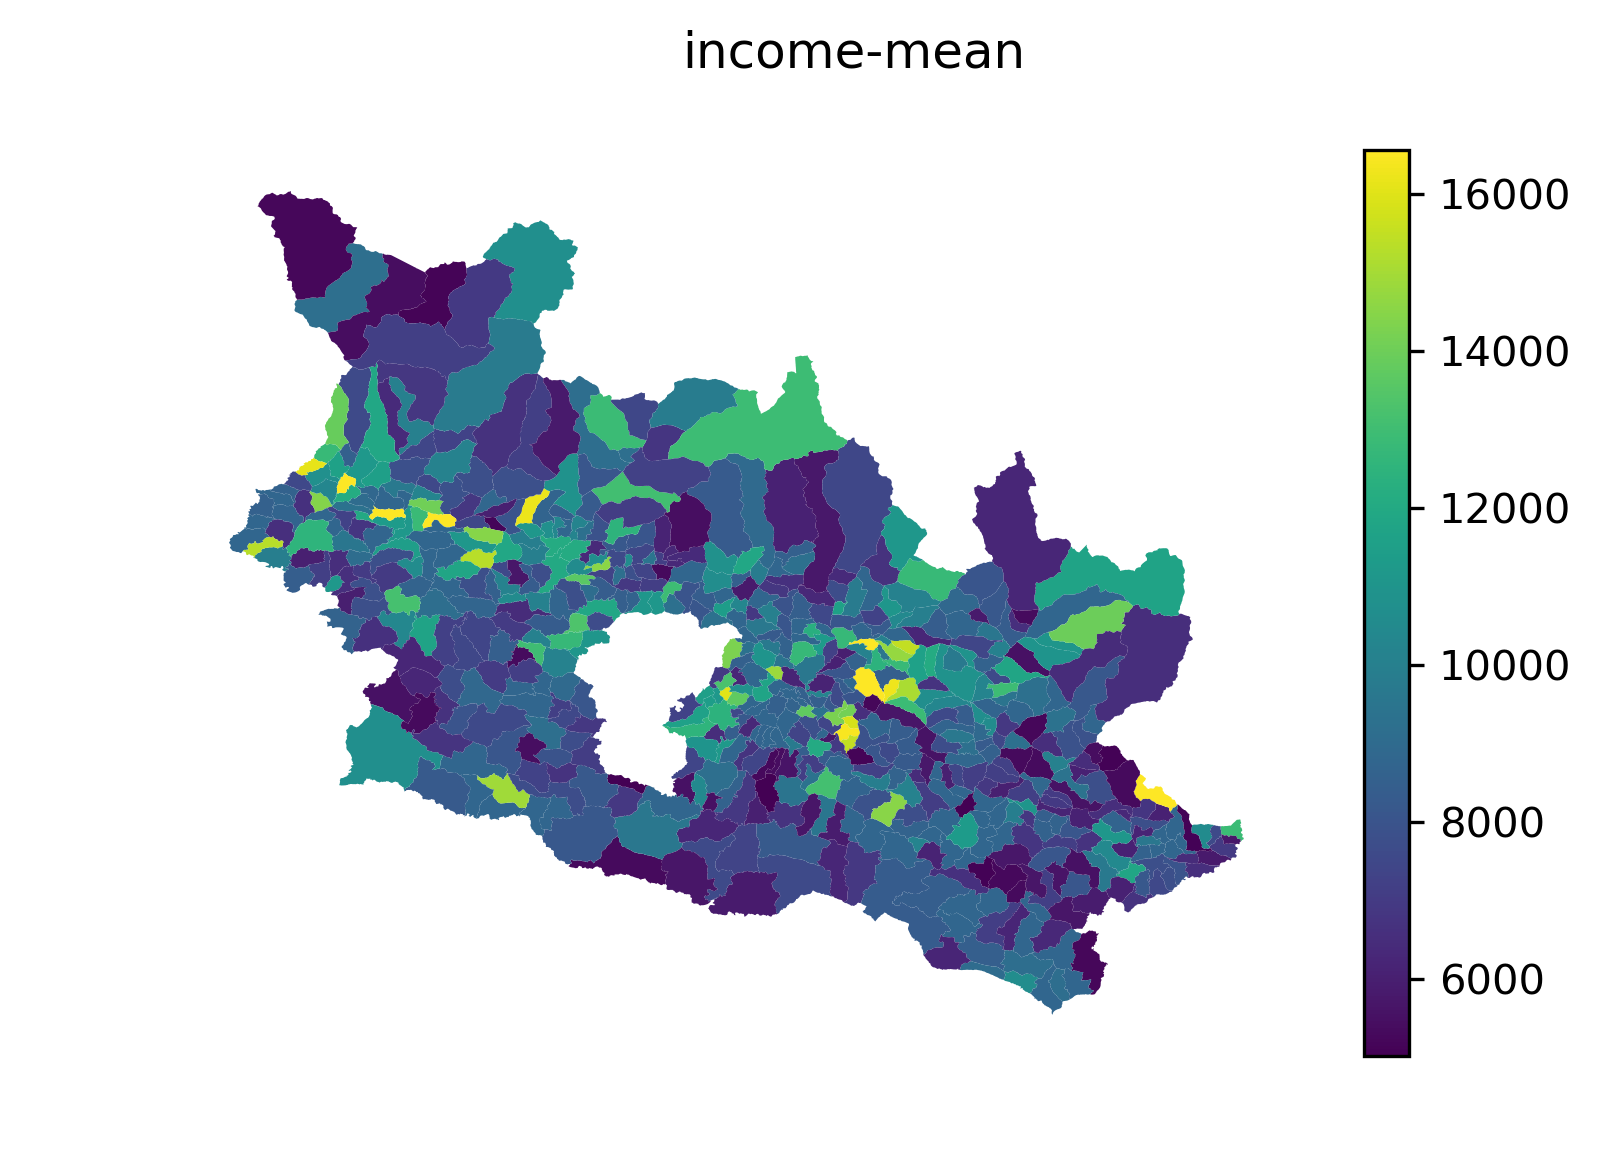

In [29]:
v = 'income'
df = village_agg_indicator(v,oper='mean')
plot_var_village(df,v,winsor=True,label=v+'-mean') 

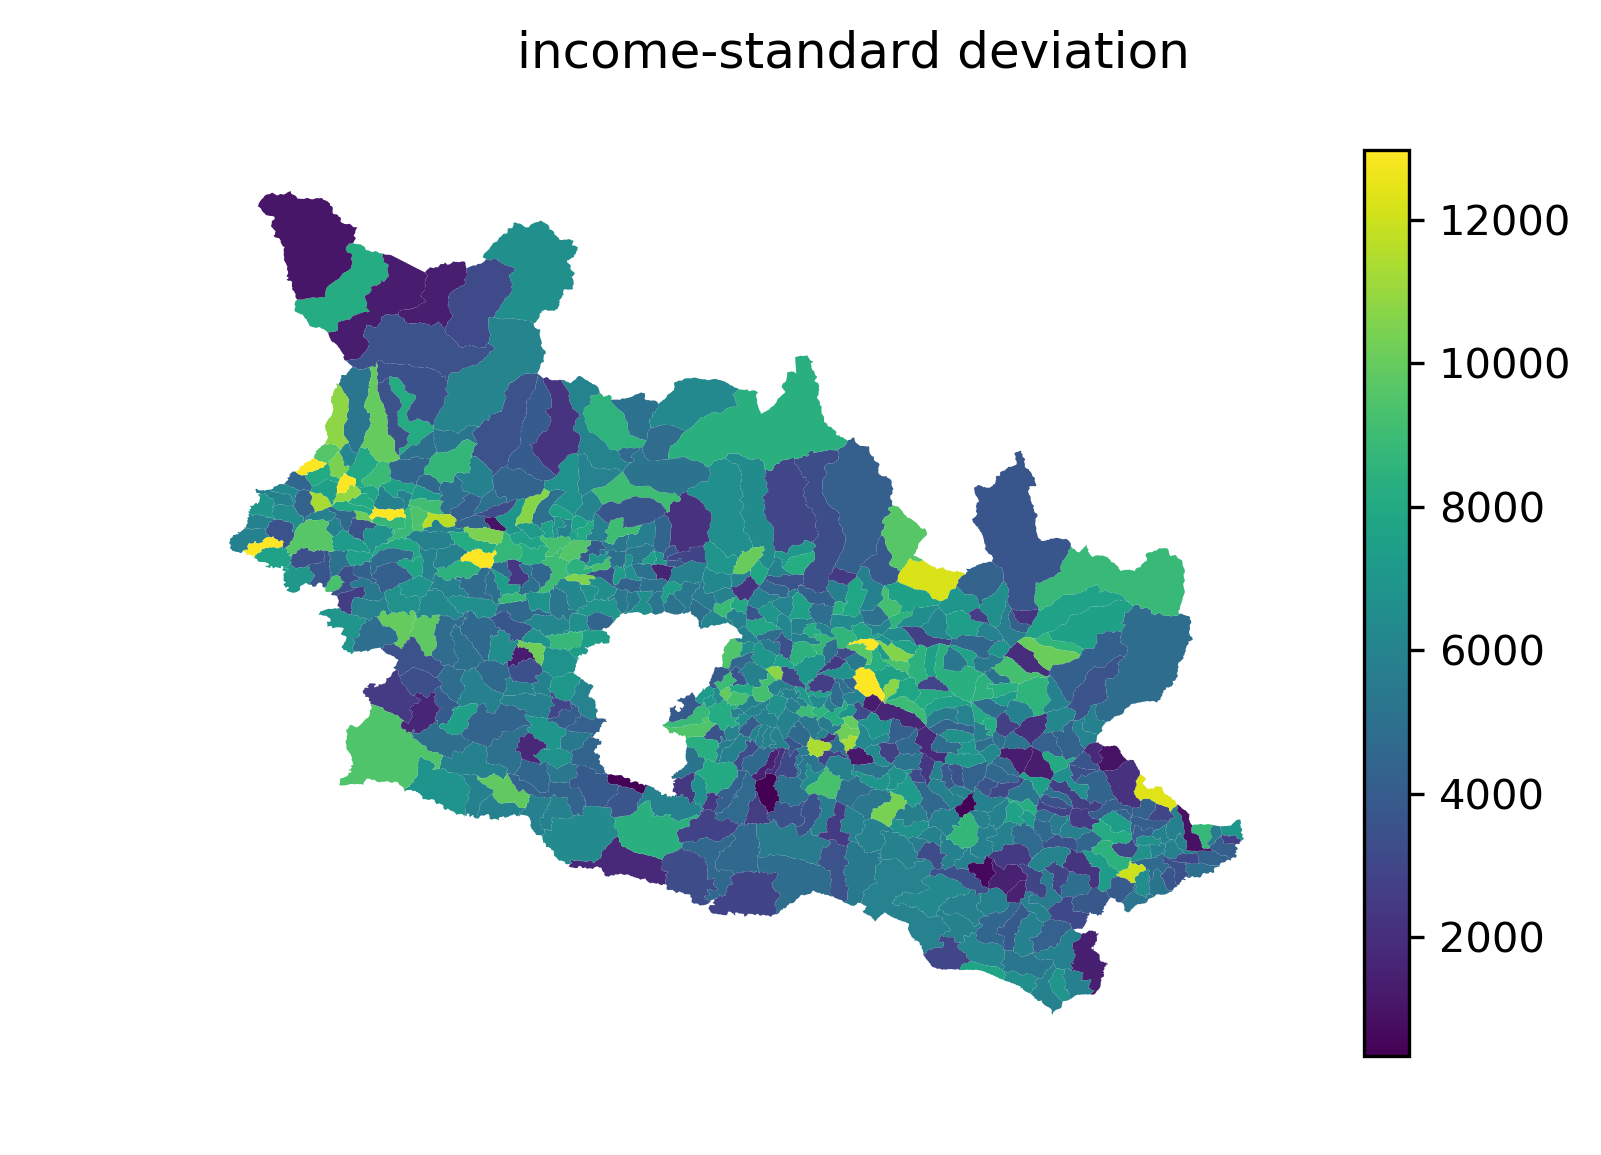

In [30]:
v = 'income'
df = village_agg_indicator(v,oper='std')
plot_var_village(df,v,winsor=True,label=v+'-standard deviation') 

## Plot all relevant variables and save

In [31]:
list_of_cols = ['is_bank_account_present_in_household',
    'has_injury_loss_occurred_last_12_months',
    'has_death_occurred_last_12_months',
    'has_education_drop_occurred_last_12_months',
    'has_pregnancy_treatment_drop_occurred_last_12_months',
    'has_vaccination_drop_occurred_last_12_months',
    'has_occupation_change_occurred_last_12_months',
    'count_occupation_change_last_12_months',
    'is_recipient_rahat_15k', 'is_recipient_rahat_10k',
    'is_recipient_rahat_200k', 'is_recipient_rahat_social_security_3k',
    'is_recipient_rahat_none', 'is_ineligible_rahat',
    'has_asset_land_pre_eq', 'has_asset_tv_pre_eq',
    'has_asset_cable_pre_eq', 'has_asset_computer_pre_eq',
    'has_asset_internet_pre_eq', 'has_asset_telephone_pre_eq',
    'has_asset_mobile_phone_pre_eq', 'has_asset_fridge_pre_eq',
    'has_asset_motorcycle_pre_eq',
    'has_asset_four_wheeler_family_use_pre_eq',
    'has_asset_four_wheeler_commercial_use_pre_eq', 'has_asset_none_pre_eq',
    'has_asset_land_post_eq', 'has_asset_tv_post_eq',
    'has_asset_cable_post_eq', 'has_asset_computer_post_eq',
    'has_asset_internet_post_eq', 'has_asset_telephone_post_eq',
    'has_asset_mobile_phone_post_eq', 'has_asset_fridge_post_eq',
    'has_asset_motorcycle_post_eq',
    'has_asset_four_wheeler_family_use_post_eq',
    'has_asset_four_wheeler_commercial_post_eq', 'has_asset_none_post_eq'
]

In [32]:
%cd $maproot

/home/alal/Desktop/code/eq-svy-eda/reports/maps


In [33]:
! mkdir 'village_level' -p

In [34]:
%cd 'village_level'

/home/alal/Desktop/code/eq-svy-eda/reports/maps/village_level


In [35]:
%%capture
for v in list_of_cols:
    plot_var_village(village_agg_indicator(v),
                     v,winsor=True,save=True)

## Village level by district 

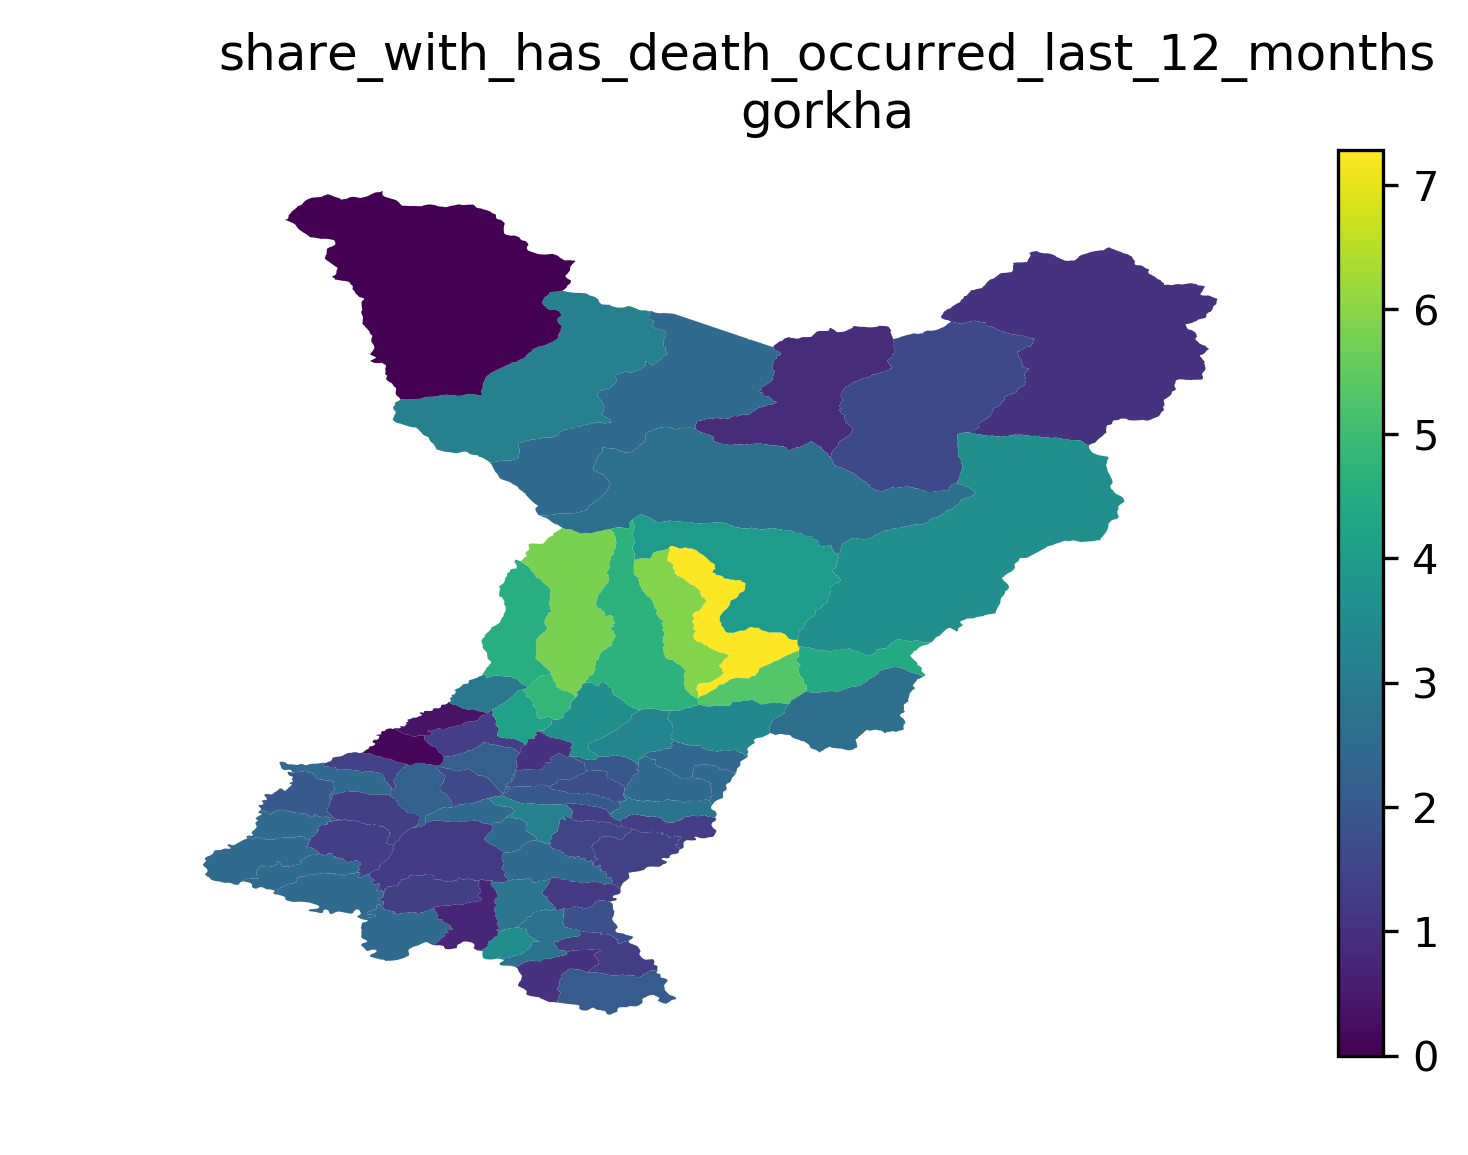

In [36]:
v = 'has_death_occurred_last_12_months'
df = village_agg_indicator(v)
plot_var_village(df,v,dist='gorkha',winsor=True)

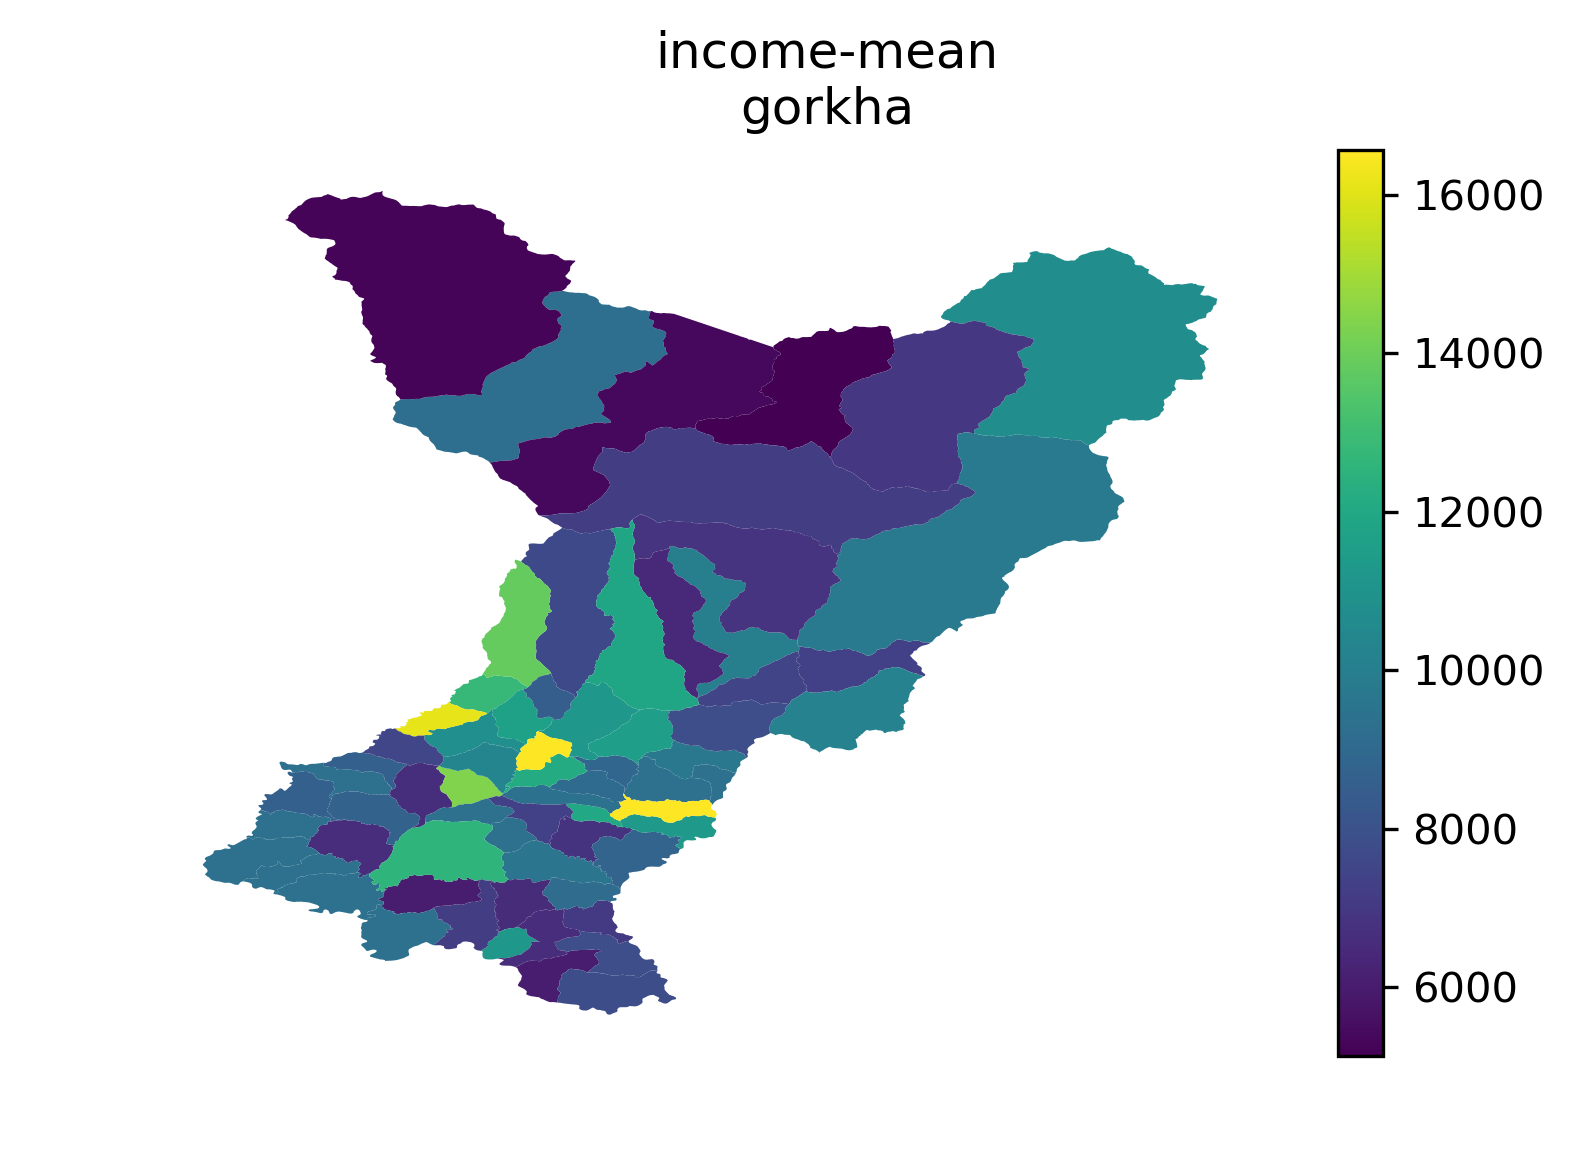

In [37]:
v = 'income'
d = 'gorkha'
df = village_agg_indicator(v,oper='mean')
plot_var_village(df,v,dist=d,winsor=True,label=v+'-mean') 

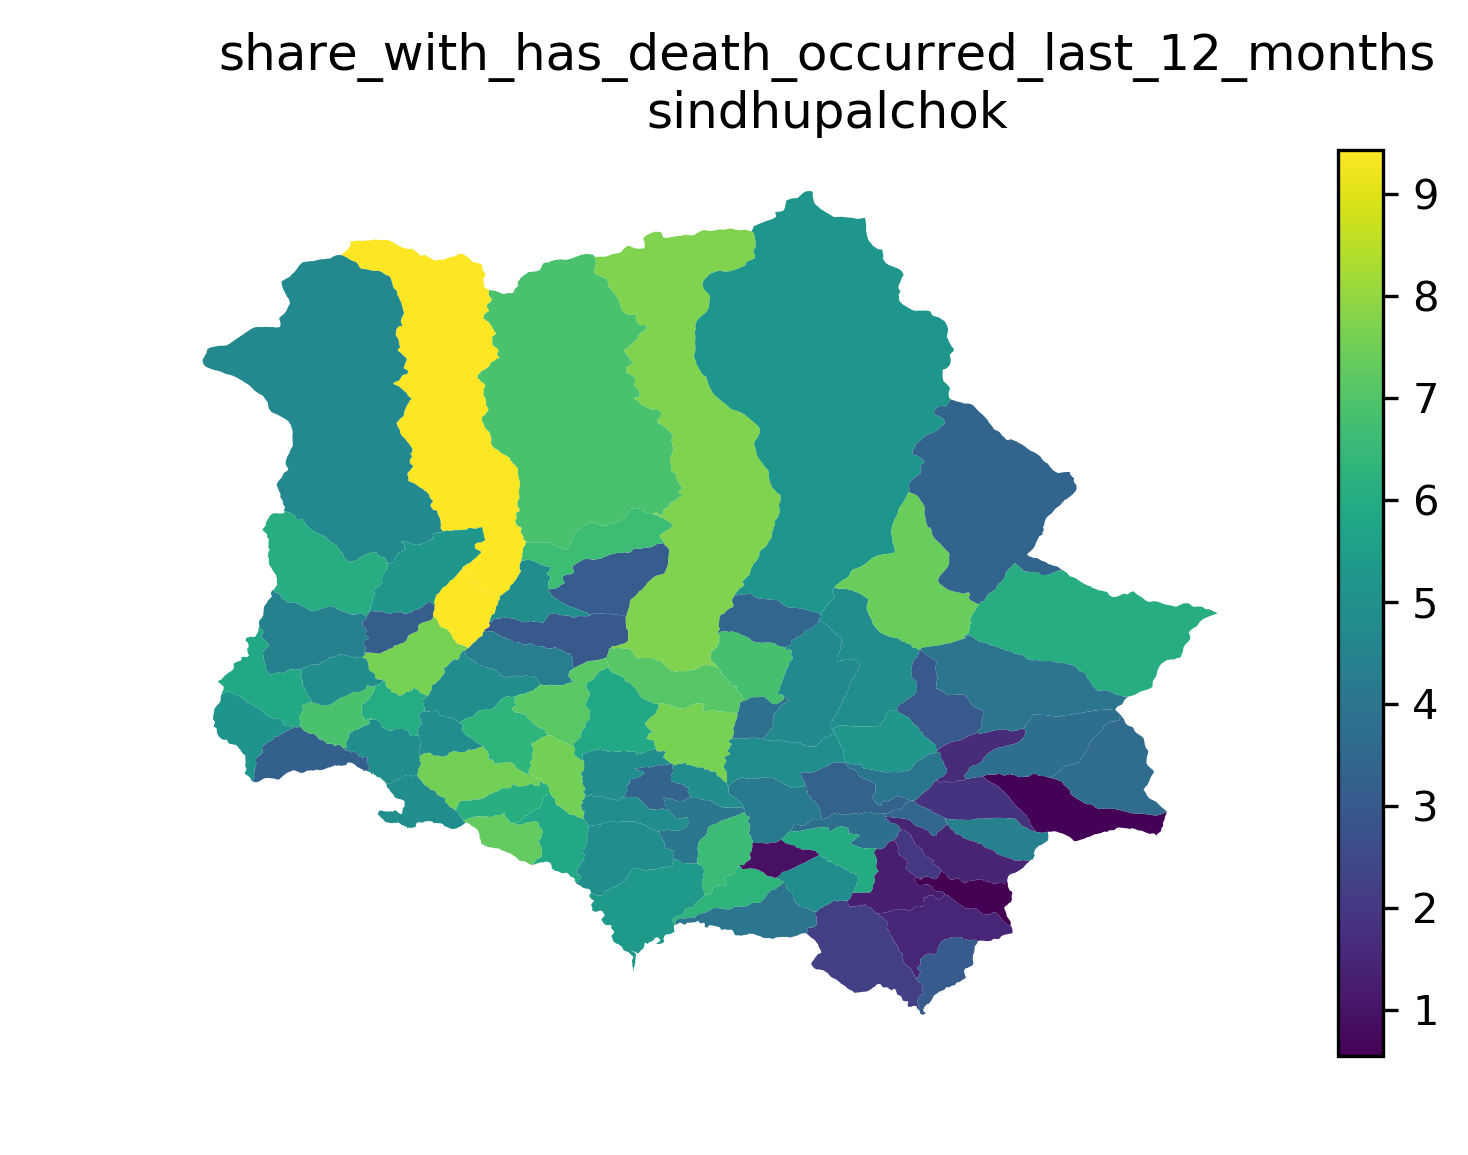

In [38]:
v = 'has_death_occurred_last_12_months'
d = 'sindhupalchok'
df = village_agg_indicator(v)
plot_var_village(df,v,dist=d,winsor=True)

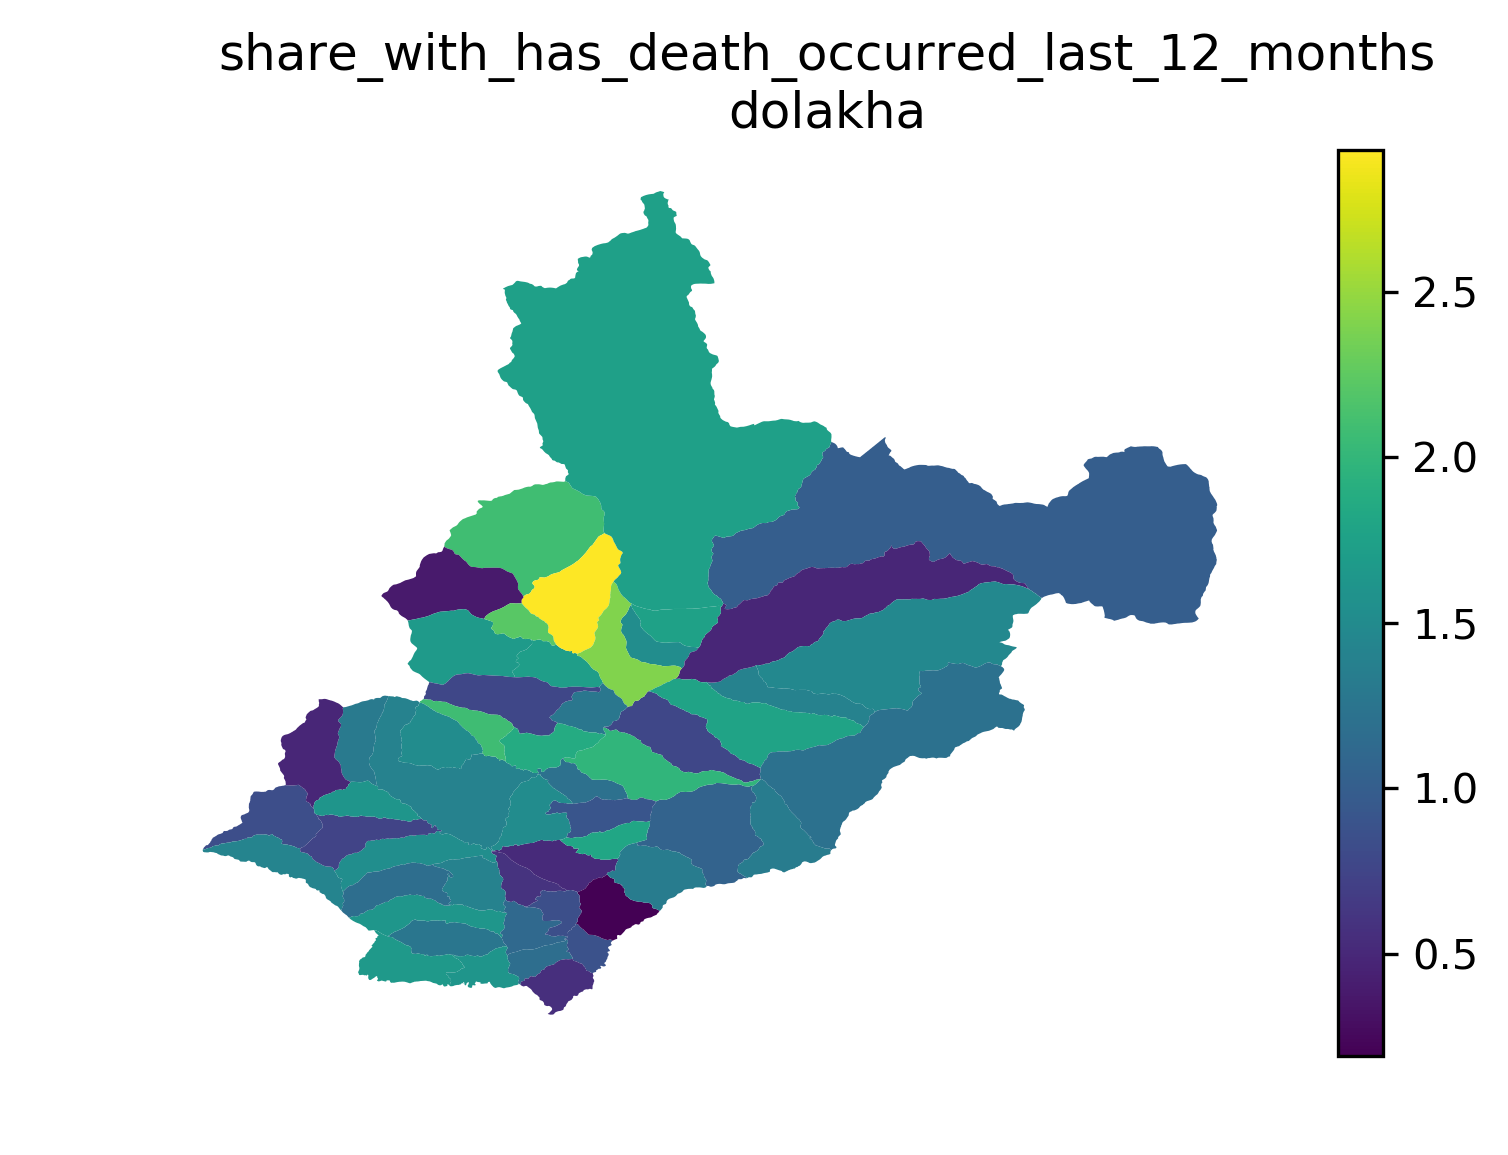

In [39]:
v = 'has_death_occurred_last_12_months'
d = 'dolakha'
df = village_agg_indicator(v)
plot_var_village(df,v,dist=d,winsor=True)

In [40]:
village_root = maproot+'/village_level'

In [41]:
%%time 
%%capture
for d in main_dists:
    os.chdir(village_root)
    dist_folder = village_root+'/'+d
    if not os.path.exists(dist_folder):
        os.makedirs(dist_folder)
    os.chdir(dist_folder)
    for v in list_of_cols:
        plot_var_village(village_agg_indicator(v),v,
                         dist=d,winsor=True,save=True)

CPU times: user 6min 51s, sys: 2min 53s, total: 9min 45s
Wall time: 5min 31s
